# Monte Carlo Methods
 This is a 2 hour workshop exploring the fundamentals of Monte Carlo methods as used in particle physics and astronomy.
 The workshop is designed to be run in a Jupyter notebook
 
 By the end of this workshop you will have explored the core concepts of:
 1. Probability distributions
 2. Samples
 3. Sampling
 4. Monte Carlo integration
 
 and the fundamental concepts of the core tools we use to do this.

## 0. Setup
 I will presume that none of these commands are unfamiliar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## 1. Probability distributions
 
 __Recap:__ a probability distribution $P$ on a variable $x$ is defined such that 
  $$P(a<x<b) = \int_a^b P(x) dx,$$
 or equivalently that $P(x)dx$ represents the probability that $x$ lies in the interval $[x,x+dx]$.

 Probability distributions are the building blocks of a lot of code, for example a cross section in particle physics:
 $$ \sigma = \int |\mathcal{M}|^2 d\Omega$$
 the matrix element $|\mathcal{M}|^2$ is a distribution over collision events.

 In Cosmology, these will be posterior distributions $\mathcal{P}(\theta|D)$ generated from cosmological likelihoods $\mathcal{L}(D|\theta)$.

 The [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) module is full of a whole variety of distributions, which forms the basis of a lot of other software.
 Let's create a [von Mises distribution](https://en.wikipedia.org/wiki/Von_Mises_distribution) (an example you may not have seen before), rather than starting with a boring normal distribution
 $$P(x) = \frac{e^{\kappa \cos(x-\mu)}}{2\pi I_0(\kappa)}.$$

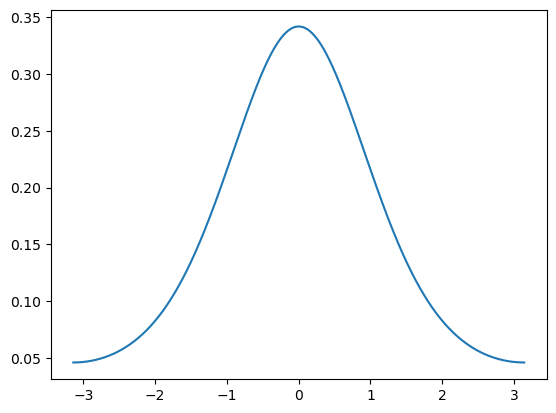

In [2]:
kappa = 1
mu = 0
dist = scipy.stats.vonmises(kappa, mu)
x = np.linspace(-np.pi, np.pi, 1000)
p = dist.pdf(x)
plt.plot(x, p);

__Exercise 1.1:__ produce a plot showing different choices of `kappa` and `mu`?

In [3]:
# Answer
# Write your answer here into this code block

uncomment and execute the below to see the solution (only after you've had a go yourself).

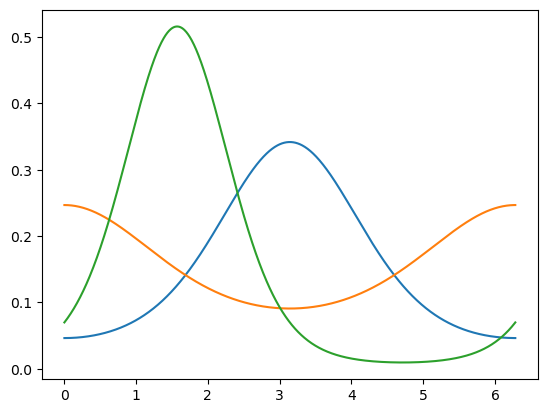

In [4]:
# %load solutions/1.1.py
for kappa, mu in [(1,np.pi), (0.5,0), (2,np.pi/2)]:
    dist = scipy.stats.vonmises(kappa, mu)
    x = np.linspace(0, 2*np.pi,1000)
    p = dist.pdf(x)
    plt.plot(x, p);

- __Question 1.1.1:__ What happens to the plot if you set `kappa` very large?
   - __Answer 1.1.1:__ _insert_
 The height of the distribution is very large, obscuring other distributions. For this reason, many plotting packages normalise the heights to 1

- __Question 1.1.2:__ [extension] Try out a few other distribution
   - __Answer 1.1.2:__ _insert_
 try anything from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) list.

### Two dimensional distributions
 These concepts are extended relatively straightforwardly to two-dimensional distributions $P(x,y)

 For a two-dimensional [von mises Fisher distribution](https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution) we can plot it as a contour plot:

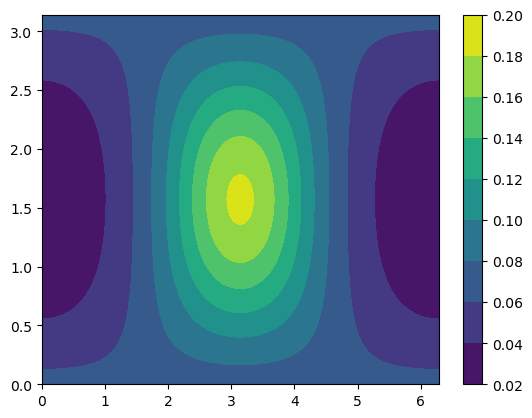

In [5]:
# Define the parameters of von-mises in terms of concentration kappa and mean direction (phi0, theta0)

def vmf_dist(kappa, phi, theta):
    mu = np.array([np.cos(phi)*np.sin(theta),
                   np.sin(phi)*np.sin(theta),
                   np.cos(theta)])
    return scipy.stats.vonmises_fisher(mu, kappa)

kappa = 1
phi0 = np.pi
theta0 = np.pi/2
dist = vmf_dist(kappa, phi0, theta0)

# Compute a meshgrid 
phi, theta = np.linspace(0, 2*np.pi, 100), np.arccos(np.linspace(1, -1, 100))
phi, theta = np.meshgrid(phi, theta)
x, y, z  = np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)

# Compute the pdf on the meshgrid with numpy broadcasting
x = np.stack([x, y, z], axis=2)
pdf = dist.pdf(x)
plt.contourf(phi, theta, pdf)
plt.colorbar();

__Exercise 1.2:__ Copy and paste the above code and adjust it to get an understanding of the effect of  `kappa` and `mu`.

In [6]:
# Answer
# Write your answer here into this code block

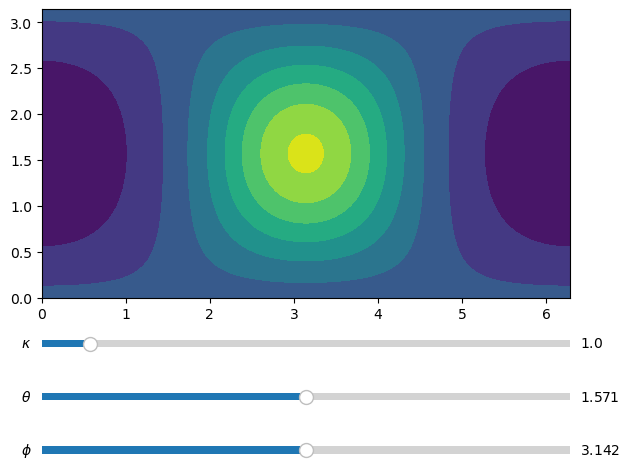

In [7]:
# %load solutions/1.2.py
fig, axes = plt.subplots(4, gridspec_kw={'height_ratios':[20,1,1,1]})

def update(ax):
    dist = vmf_dist(kappa_slider.val, phi0_slider.val, theta0_slider.val)
    pdf = dist.pdf(x)
    axes[0].cla()
    axes[0].contourf(phi, theta, pdf)

from matplotlib.widgets import Slider
kappa_slider = Slider(axes[1], r'$\kappa$', 0.1, 10, valinit=1)
theta0_slider = Slider(axes[2], r'$\theta$', 0, np.pi, valinit=np.pi/2)
phi0_slider = Slider(axes[3], r'$\phi$', 0, 2*np.pi, valinit=np.pi)

update(None)

kappa_slider.on_changed(update)
theta0_slider.on_changed(update)
phi0_slider.on_changed(update)
fig.tight_layout()

- __Question 1.2.1:__ What do the colours represent?
   - __Answer 1.2.1:__ _insert_
 The colours above correspond to a matplotlib default colour scheme mapped to the values of the probability density.

- __Question 1.2.2:__ What is the relevance of the `arccos` in the above?
   - __Answer 1.2.2:__ _insert_
 Compensates for the usual $\sin\theta d\theta d\phi$ area element, or equivalently forces it to be uniform in $z$. This is critical later when we compute the the one sigma and two sigma contours, by assuming that the theta, phi distribution are distributed uniformly in the prior/measure.

It is more usual to plot 'one sigma' and 'two sigma' contours.

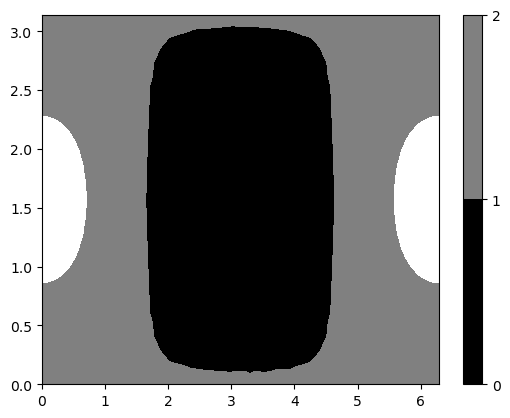

In [8]:
pdf = dist.pdf(x)
pdf = pdf.reshape(-1)
i = np.argsort(pdf)
cdf = pdf[i].cumsum()
cdf /= cdf[-1]
sigma = np.empty_like(pdf)
sigma[i] = np.sqrt(2) * scipy.special.erfinv(1-cdf)
sigma = sigma.reshape(phi.shape)
plt.contourf(phi, theta, sigma, levels=[0, 1, 2], colors=['black', 'gray'])
plt.colorbar();

- __Question 1.3.1:__ What exactly do "one sigma" and "two sigma" contours mean, and how does the above code compute them?
   - __Answer 1.3.1:__ _insert_
 iso-probability contours containing probability mass 66.7\% and 95.4\%. The first portion of the code computes the cumulative distribution function as a function of probability density. The erfinv function translates mass into sigma.

- __Question 1.3.2:__ How should one choose the colours for the contours? (have a look at the [anesthetic](https://github.com/handley-lab/anesthetic#another-posterior-plotting-tool) README for one option for doing this.
   - __Answer 1.3.2:__ _insert_
 anesthetic chooses this by colouring in proportion to the probability, which means that for close-to-uniform distributions the 2 sigma contour colouring does not look significantly different from the 1 sigma contour colouring.

__Beware:__ [corner.py](https://corner.readthedocs.io/en/latest/pages/sigmas/) uses a different definition of sigma.

### Higher dimensional distributions
 In most cases we have far more than two variables, which makes plotting the full distribution difficult.
 
 The best we can do visually is to plot the _marginal distributions_, i.e. the distributions with each other variable integrated out. Since 1D and 2D distributions are plottable, we typically do this by considering the 1D marginals individually:
 $$ P(x_i) = \int P(x) \prod\limits_{k\ne i} dx_k$$
 and pairwise marginals
 $$ P(x_i, x_j) = \int P(x) \prod\limits_{k\ne i, k\ne j} dx_k$$
 and arrange these into a "corner" or "triangle" plot.

This example takes a few seconds to generate and plot -- don't worry about the code details, we will cover them later:

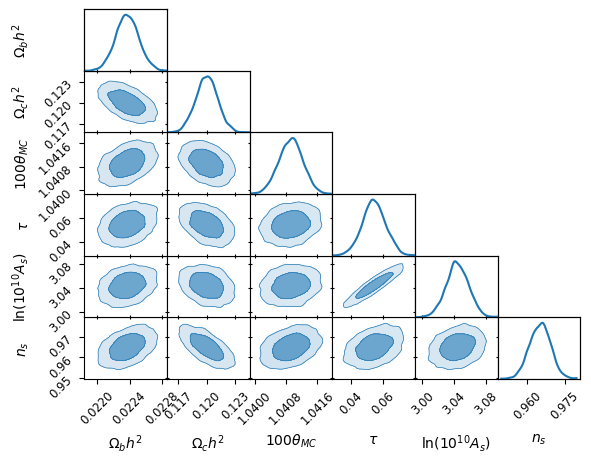

In [9]:
from anesthetic.examples.perfect_ns import planck_gaussian
params = ['omegabh2', 'omegach2', 'theta', 'tau', 'logA', 'ns']
planck_samples = planck_gaussian()[params].compress()
planck_samples.plot_2d(kind='kde');

The next section builds up to how we go about producing these plots in practice.

## 2. Samples: why do sampling?
 
 The core concept in numerical inference is that of _samples_. The premise is straightforward -- given some density $P(x)$, generate random numbers whose density in the large-number limit is equal to $P(x)$.

 `scipy.stats` functions have the 'random variables' `.rvs()` method built in, which does exactly this.

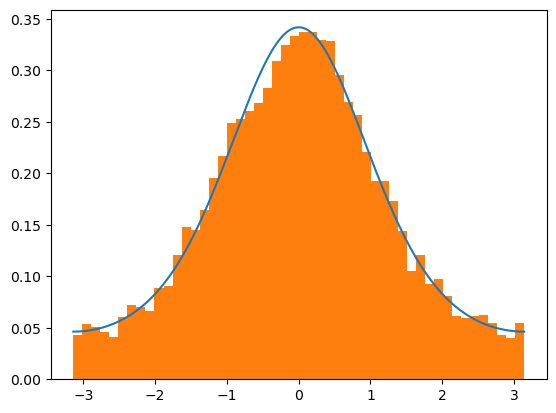

In [10]:
kappa = 1
mu = 0
dist = scipy.stats.vonmises(kappa, mu)
x = np.linspace(-np.pi, np.pi, 1000)
p = dist.pdf(x)
plt.plot(x, p);
samples = dist.rvs(10000)
plt.hist(samples, density=True, bins=50);

- __Question 2.1.1:__ what is the relevance of the `density=True` and `bins=50` arguments to `plt.hist`?
   - __Answer 2.1.1:__ _insert_
 `density=True` normalises the y axis to be the same as the probability density
 `bins=50` makes the histogram have 50 bins, which is slightly nicer than the default matplotlib binning

We can also sample from the 2D distribution we defined above:

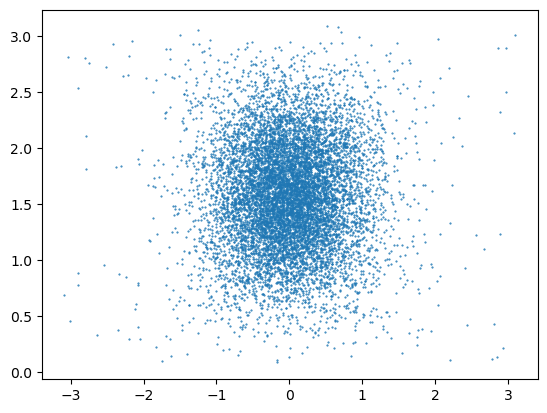

In [11]:
kappa = 4
phi0 = 0
theta0 = np.pi/2
dist = vmf_dist(kappa, phi0, theta0)
N = 10000
samples = dist.rvs(N)
theta, phi = np.arccos(samples[:,2]), np.arctan2(samples[:,1], samples[:,0])
plt.plot(phi, theta, '.', markersize=1);

One of the lesser-know functionalities of matplotlib is that the samples above can also be used to plot contours with the triangulation functionality provided by the `tricontourf` method:

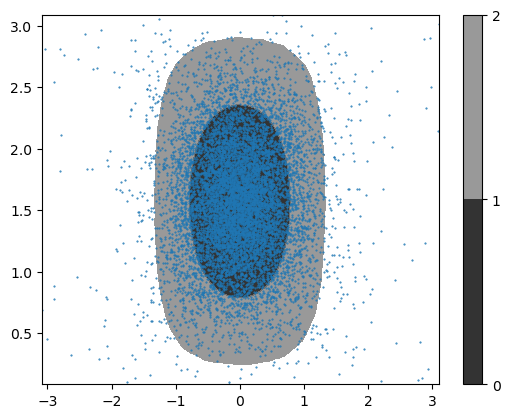

In [12]:
pdf = dist.pdf(samples)
i = np.argsort(pdf)
cdf = np.arange(1,N+1)/(N+1)
sigma = np.empty_like(pdf)
sigma[i] = np.sqrt(2) * scipy.special.erfinv(1-cdf)
plt.tricontourf(phi, theta, sigma, levels=[0, 1, 2], colors=['black', 'gray'], alpha=0.8)
plt.plot(phi, theta, '.', markersize=1)
plt.colorbar();

- __Question 2.2.1:__  Why is the sigma calculation different in comparison to the previous example? [hard]
   - __Answer 2.2.1:__ _insert_
 Because in the first case we were using grid points (uniform in prior), whilst now we are using samples (uniform in posterior). This difference in measure means that we no longer need to introduce pdf terms into the cdf, since samples drawn from the distribution will populate it's CDF uniformly.

One way to see how powerful the above approach of using samples to make plots is, is to consider how we might go about making the triangle plot using the meshgrid approach. To do this, we would have to solve two problems:
 - __Question 2.3.1:__ How would you use a meshgrid to compute marginal distributions?
   - __Answer 2.3.1:__ _insert_
 sum down the other axes of the hypergrid

- __Question 2.3.2:__ How much more expensive would this be in 6 dimensions?
   - __Answer 2.3.2:__ _insert_
 This is exponentially more expensive. If the grid size were 10, then the cost of a 2D problem is ~10^2, whilst the cost of a 6D problem is ~10^6, so it woul be 10^4 times harder for a 10 point grid, and 20^4 times harder for a 20 point grid.

Sampling solves both of these:
 - marginal samples are found just by ignoring columns
 - drawing samples from higher-dimensional distributions is not exponentially harder
 To see this, let's take a look at the planck_samples, which when printed show an anesthetic (pandas extension) array

In [13]:
planck_samples

,omegabh2,omegach2,theta,tau,logA,ns
labels,$\Omega_b h^2$,$\Omega_c h^2$,$100\theta_{MC}$,$\tau$,${\rm{ln}}(10^{10} A_s)$,$n_s$
18485,0.022664,0.116639,1.041485,0.077081,3.068243,0.970429
18530,0.022075,0.119423,1.040727,0.044626,3.027876,0.954736
18532,0.022592,0.121253,1.040081,0.057878,3.052486,0.967304
18533,0.022451,0.120088,1.041034,0.042012,3.041327,0.958808
18590,0.022516,0.120008,1.040924,0.033814,2.990549,0.966804
...,...,...,...,...,...,...
27018,0.022379,0.119804,1.040908,0.051935,3.039095,0.966486
27033,0.022393,0.119997,1.041025,0.057620,3.049483,0.964584
27674,0.022442,0.119667,1.040985,0.056623,3.048812,0.966005


We can plot samples from the marginal distribution by

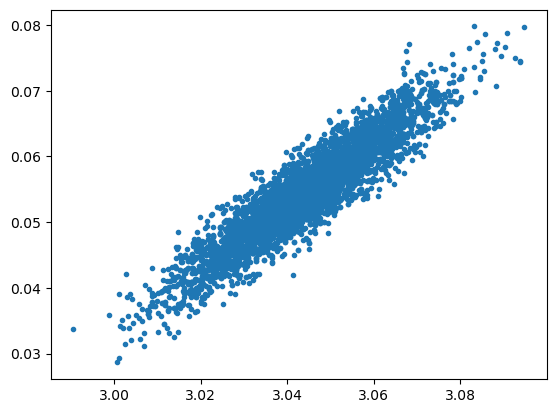

In [14]:
plt.plot(*planck_samples[['logA', 'tau']].to_numpy().T, '.');

To plot the marginal contours, we have to use some form of low-dimensional density estimation. Kernel density estimation (KDE) is the standard (basically putting a small gaussian on each sample and adding these together) but in principle one could use neural density estimators or histograms for more/less advanced versions. Density estimation is an acceptable approximation in one and two dimensions but becomes very innacurate in higher dimensions.

There are many packages that implement all of this for you, and I would encourage you to resist the temptation to write your own! (irony noted)
 - [getdist](https://getdist.readthedocs.io/en/latest/)
   - state-of-the-art in KDE edge correction
   - industry standard since 2010
   - difficult to extend/use
 - [corner.py](https://corner.readthedocs.io/en/latest/)
   - histogram-based foreman-mackay software
 - [chainconsumer](https://samreay.github.io/ChainConsumer/)
   - increasingly popular python tool for MCMC samples
 - [anesthetic](https://anesthetic.readthedocs.io/en/latest/)
   - specialised for nested sampling, but can also do MCMC
   - explicitly builds on the numpy/scipy/pandas stack.
 
 You can see here that the python package anesthetic by default uses the whitespace above the diagonal to plot samples, in addition to estimates of the 1D and 2D marginals:

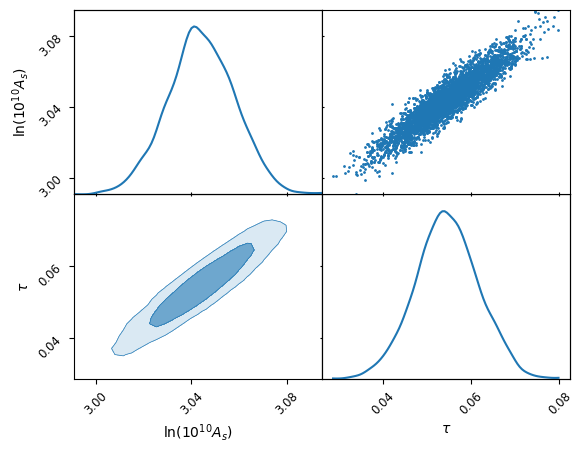

In [15]:
planck_samples[['logA', 'tau']].plot_2d();

Samples are an extremely powerful tool for performing numerical inference. In particular the following property holds
 $$ x\sim P(x)dx \quad\Rightarrow\quad f(x) \sim P(f)df$$
 namely, if you have a set of samples in a variable $x$, and you want to know how $y=f(x)$ is distributed, you just assume the answer is $x_i$ and compute $y_i = f(x_i)$ for each sample. Sampling turns uncertainty quantification into repeated forward models.

__Exercise 2.4:__ if $x$ is normally distributed, plot the distribution of $2^xx$. Bonus question: prove mathematically that in this case x is log-normally distributed, find its scale parameter, and plot this on your plot.

In [16]:
# Answer

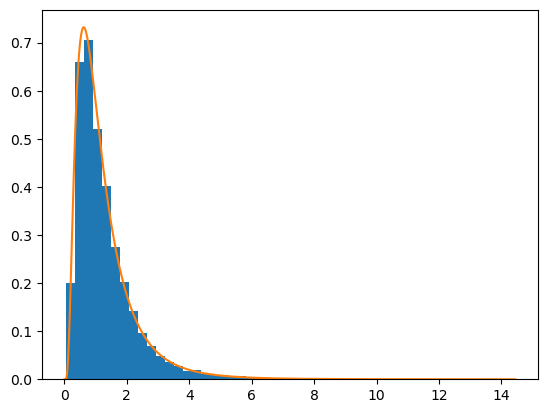

In [17]:
# %load solutions/2.4.py
x = scipy.stats.norm().rvs(10000)

def f(x):
    return 2**x

plt.hist(f(x), bins=50, density=True)
x_ = np.linspace(0, f(x).max(), 1000)
s = np.log(2)
plt.plot(x_, scipy.stats.lognorm(s).pdf(x_))

One can compute averages by summing over samples:
 $$ \langle f \rangle_P \quad=\quad \int f(x) P(x) dx \quad\approx\quad \frac{1}{N} \sum\limits_{i=1}^N f(x_i)$$
 Note that the (generally unknown) density __does not__ appear in the final expression, which shows that sampling is our primary tool for avoiding high-dimensional density estimation.

To confuse you on this last point, most methods for generating samples will often create _weighted samples_, namely each sample $x_i$ has an associated weight $w_i$, and the average is computed as:
 $$ \langle f \rangle_P \quad\approx\quad \tfrac{1}{\sum_i w_i}\sum_i w_i f(x_i)$$
 This weight is __not__ generally the probability density.

 `anesthetic` is a pandas extension which computes weighted statistics.

In [18]:
from anesthetic import Samples

x = np.random.rand(100,3)
w = np.random.rand(100)
samples = Samples(x, weights=w)
samples

,,0,1,2
,weights,,,
0,0.762460,0.267808,0.205305,0.891824
1,0.021532,0.497208,0.130231,0.677197
2,0.974721,0.901009,0.744686,0.020382
3,0.363625,0.515908,0.203300,0.272930
4,0.070767,0.216768,0.243556,0.085525
...,...,...,...,...
95,0.893352,0.224187,0.329500,0.617385
96,0.202672,0.276994,0.478984,0.775145
97,0.340925,0.170483,0.111730,0.020087


In [19]:
samples.mean()

0    0.483981
1    0.487189
2    0.532269
dtype: float64

In [20]:
samples.std()

0    0.300050
1    0.281983
2    0.281581
dtype: float64

Exercise 2.5: confirm that the the weighted mean and standard deviation are not the same as numpy's default.

In [21]:
# Answer

In [22]:
# %load solutions/2.5.py
print(np.mean(x, axis=0) - samples.mean())
print(np.std(x, axis=0) - samples.std())

0   -0.007400
1   -0.016036
2   -0.011612
dtype: float64
0   -0.014053
1   -0.001135
2    0.005017
dtype: float64


Getting weighted means and standard deviations correct is a faff, and a common source of bugs in numerical inference code, so it's worth being aware of this/using anesthetic's extensive functionality.

### Summary
 Samples are the fundamental building block of numerical inference. You should view them as "souped-up error bars", summarising uncertainty in your analysis. If you have an analysis that you could do if you knew all the inputs $x$, and you have samples from the distribution $x$ belongs to, you just do the analysis $N$ times for each sample, get $N$ answers, and the distribution of these answers quantifies your uncertainty.

 The golden rule of Numerical inference is therefore to __stay in samples__ until the end. You should know by now that in general
 $$f(\langle x \rangle) \ne \langle f(x) \rangle $$
 so taking an average/summary before the end can bias your inference.

 You can then use samples to compute averages, and extract marginal distributions by ignoring columns, from which you can compute 1D and 2D contours. This is the basis of the triangle plot.

 __Question 2.6:__ [hard] what statistical operation can you not get easily from samples?

We now move on to techniques as to how one can generate samples from an arbitrary distribution.

## 3. Sampling
 We will assume that we can evaluate the probability density function $P(x)$ (or at least the unnormalised density $P^*(x)\propto P(x)$) in finite time (i.e. seconds). For initiates, it might be surprising that access to the exact $P(x)$ is not sufficient to generate samples, but it is not.

(N.B. The frontier of inference at the moment is simulation based inference, which develops methods for inference when you only have a simulator $f(x)$, but this is beyond the scope of this workshop).

### 3.0 Random sampling
 Let's first see why random sampling is not sufficient.

In [23]:
from handleymcmethods.examples import planck

__Exercise 3.0.1:__ Generate 10000 samples from planck.prior, and find the largest planck.loglikelihood value in the samples. Repeat this process a few times. What do you notice?

In [24]:
# Answer

In [25]:
# %load solutions/3.0.1.py
samples = planck.prior.rvs(size=(10000,6))
logL = planck.loglikelihood(samples)
print(np.max(logL))

-8606.264897167139


The issue is that the prior is much wider than the likelihood/posterior, so random samples are very unlikely to be close to the peak of the likelihood. This same problem would occur for meshgrid sampling.

 One solution for finding a good region is of course a gradient descent
 __Exercise 3.0.2:__ Use `scipy.optimize.minimize` to find the maximum of the loglikelihood. How does this compare to the maximum of the other results

In [26]:
# Answer

In [27]:
# %load solutions/3.0.2.py
def f(x):
    return -planck.loglikelihood(x)

while True:
    x0 = planck.prior.rvs()
    sol = scipy.optimize.minimize(f, x0)
    if sol.success:
        break

print(sol.x)
print(sol.x-planck.mean)
print(planck.loglikelihood(sol.x))

[0.02236999 0.12000005 1.04091998 0.05439975 3.04399954 0.96489985]
[-1.24872248e-08  5.01684146e-08 -1.80391335e-08 -2.54780979e-07
 -4.64952619e-07 -1.54393540e-07]
-1397.3500000041402


Whilst this approach does find the maximum probability point, this does not generate samples, which is what we need for our error bars.

### 3.1 Metropolis Hastings

 The first approach that can successfully generate samples from a distribution is the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).
 The simplest version of this algorithm is as follows:
 - start at some point $x_0$
 - at iteration $i$: 
   - propose a new point $x'$ a random step away from $x_i$
   - accept the point with probability
   $$ \alpha = \frac{P(x')}{P(x_i)}$$
   - if the point is accepted, $x_{i+1} = x'$, otherwise $x_{i+1} = x_i$
   - stop when you have enough samples

__Exercise 3.1.1:__ Implement the Metropolis-Hastings algorithm for the planck likelihood. 
 - hint: if it's not working, try plotting the the set of points you're generating

In [28]:
# Answer

/tmp/ipykernel_656411/3818313480.py:9: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(logalpha)


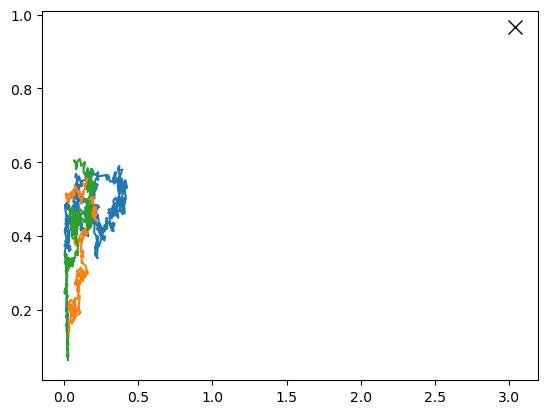

In [29]:
# %load solutions/3.1.1.py
N = 10000
for _ in range(3):
    x0 = planck.prior.rvs()
    samples = []
    for i in range(N):
        x_ = x0 + np.random.randn(len(x0))*0.01
        logalpha = planck.loglikelihood(x_) - planck.loglikelihood(x0)
        alpha = np.exp(logalpha)
        if np.random.rand() < alpha:
            x0 = x_
        samples.append(x0[:])

    samples = np.array(samples)
    plt.plot(*samples[:,[0,1]].T)

plt.plot(*planck.mean, 'x', markersize=10, color='black');

Things can be made a lot better by choosing a better method for proposing new points.
 For example, if you use the true posterior coviariance matrix, the solution converges much better
 - hint: you can get the covariance matrix from `planck.cov` and the mean from `planck.mean`

In [30]:
# Answer

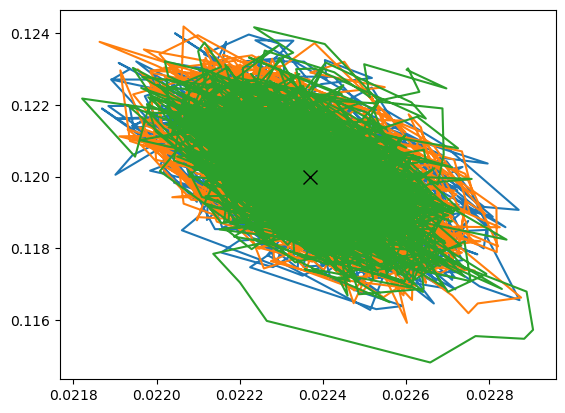

In [31]:
# %load solutions/3.1.2.py
N = 10000

def Q(x0):
    dist = scipy.stats.multivariate_normal(x0, planck.cov)
    return dist.rvs()

for _ in range(3):
    x0 = planck.mean
    samples = []
    for i in range(N):
        x_ = Q(x0)
        logalpha = planck.loglikelihood(x_) - planck.loglikelihood(x0)
        alpha = np.exp(logalpha)
        if np.random.rand() < alpha:
            x0 = x_
        samples.append(x0[:])

    samples = np.array(samples)
    plt.plot(*samples[:,[0,1]].T)

plt.plot(*planck.mean[:2], 'x', markersize=10, color='black');

Of coures in practice one doesn't know the answer going in, and therefore typically it has to be learned, either by knowing something about the physics, using another algorithm first, or gradually updating the proposal distribution.

- __Question 3.1.3:__ Where does the metropolis hastings algorithm fail?
   - __Answer 3.1.3:__ _insert_
     - poor starting point
     - too small/large a stepsize / poor proposal choice
     - Multiple modes
     - too few iterations
     - phase transitions

- __Question 3.1.4:__ How well does this algorithm parallelise?
   - __Answer 3.1.4:__ _insert_
 Not well! You could run multiple chains, but in practice most of a metropolis-hastings algorithm is spent 'burning in' to the final distribution, which is a constant cost independent of how many chains you are running. Once all the chains have converged to the distribution, nchains generate points n times faster (embaressingly parallel), but this is not where most of the cost of the algorithm is.

The full algorithm is as follows:
 - start at some point $x_0$
 - propose a new point $x'$ from some proposal distribution $Q(x'|x)$
 - accept the point with probability
 $$ \alpha = \min\left(1, \frac{P(x')Q(x|x')}{P(x)Q(x'|x)}\right)$$
 - repeat until convergence criterion is reached

 Note this includes the generalisation to asymmetric proposal distributions, which is necessary for the algorithm to converge, and more carefully acounts for the fact that the probability shouldn't be greater than 1. Convergence criteria usually include a variation of the Gelman-Rubin statistic.
 
 Example implementations of metropolis hastings include
 - [PyMC](https://www.pymc.io/welcome.html)
 - [Cobaya](https://cobaya.readthedocs.io/en/latest/)
 - [CosmoSIS](https://cosmosis.readthedocs.io/en/latest/)
 - [MontePython](https://monte-python.readthedocs.io/en/latest/)

 Though in practice, since a metropolis sampler is so easy to write, and aspects of the proposal distribution are so system-specific, many people just choose to write their own!

 More modern work is exploring the use of neural networks to learn the proposal distribution, which can be much more efficient than the above.
 - [FlowMC](https://arxiv.org/abs/2211.06397)
 - [MCMC-diffusion](https://arxiv.org/abs/2309.01454)

 Further extensions to this approach include ensemble sampling ([emcee](https://emcee.readthedocs.io)), slice sampling ([zeus](https://zeus-mcmc.readthedocs.io/en/latest/)) and many others.

### 3.2 Nested sampling

 As discussed in the [talk](https://github.com/williamjameshandley/talks/raw/unam_2023/will_handley_unam_2023.pdf), the nested sampling algorithm can be summarised as:
 - generate nlive samples from the prior
 - at each iteration, replace the lowest likelihood sample with a new sample from the prior at greater likelihood
 - stop when the live points have sufficiently compressed

__Exercise 3.2.1:__ Implement the nested sampling algorithm for the planck likelihood with 50 live points, using a brute-force prior-sample+rejection approach. How many iterations do you get through? (put in a print statement to see the slow down)

In [32]:
# Answer

In [33]:
# %load solutions/3.2.1.py
from tqdm import trange

def generate_point():
    while True:
        x = planck.prior.rvs()
        logL = planck.loglikelihood(x)
        if logL > live_logLs.min():
            break
    return x, logL

nlive = 50
live_points = planck.prior.rvs((nlive, 6))
live_logLs = planck.loglikelihood(live_points)

for i in trange(nlive*9, miniters=1):
    x, logL = generate_point()
    live_points[live_logLs.argmin()] = x
    live_logLs[live_logLs.argmin()] = logL

100%|█████████████████████████████████████████████████████████| 450/450 [00:19<00:00, 22.82it/s]


You should find you get about to about 500 iterations before you run out of patience!

__Exercise 3.2.2:__ This time, implement a more efficient approach by using a box around the live points to generate samples from the prior. To be correct, you should make the box slightly larger than this! Run the algorithm for 
 - __Question 3.2.2:__ What are the failure modes of this method?

In [34]:
# Answer

In [35]:
# %load solutions/3.2.2.py
from tqdm import trange

def generate_point(expansion = 1.1):

    while True:
        mn = live_points.min(axis=0)
        mx = live_points.max(axis=0)
        box = (mx-mn)
        mn -= box*(expansion-1)/2
        mx += box*(expansion-1)/2 
        dist = scipy.stats.uniform(mn, mx-mn)

        x = dist.rvs()
        logL = planck.loglikelihood(x)
        if logL > live_logLs.min():
            break
    return x, logL

nlive = 50
live_points = planck.prior.rvs((nlive, 6))
live_logLs = planck.loglikelihood(live_points)

for i in trange(nlive*11):
    x, logL = generate_point()
    live_points[live_logLs.argmin()] = x
    live_logLs[live_logLs.argmin()] = logL

100%|████████████████████████████████████████████████████████| 550/550 [00:02<00:00, 206.56it/s]


__Exercise 3.2.3:__ Adjust your algorithm so that it records the dead points, as well as the 'birth contour'. Plot the dead points. Pass these into the anesthetic gui

In [36]:
# Answer

100%|██████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 119.17it/s]


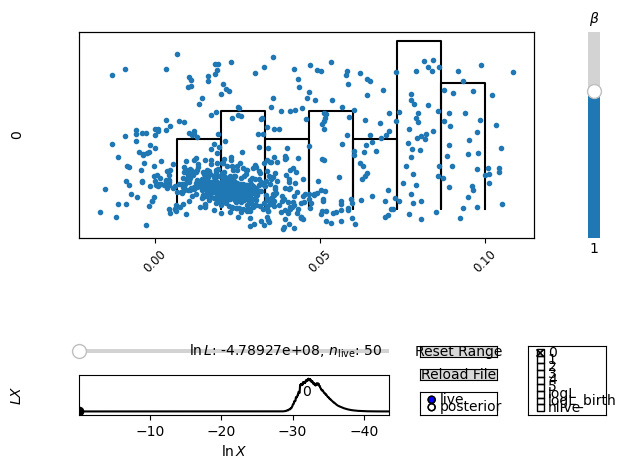

In [37]:
# %load solutions/3.2.3.py
from tqdm import trange

def generate_point(expansion = 1.1):

    while True:
        mn = live_points.min(axis=0)
        mx = live_points.max(axis=0)
        box = (mx-mn)
        mn -= box*(expansion-1)/2
        mx += box*(expansion-1)/2 
        dist = scipy.stats.uniform(mn, mx-mn)

        x = dist.rvs()
        logL = planck.loglikelihood(x)
        if logL > live_logLs.min():
            break
    return x, logL

nlive = 50
live_points = planck.prior.rvs((nlive, 6))
live_logLs = planck.loglikelihood(live_points)
live_logL_births = -np.inf * np.ones(nlive)
dead_points = []
dead_logLs = []
dead_logL_births = []

for i in trange(nlive*40):
    x, logL = generate_point()
    dead_points.append(live_points[live_logLs.argmin()].copy())
    dead_logLs.append(live_logLs.min())
    dead_logL_births.append(live_logL_births[live_logLs.argmin()])
    live_points[live_logLs.argmin()] = x
    live_logL_births[live_logLs.argmin()] = live_logLs.min()
    live_logLs[live_logLs.argmin()] = logL

dead_points += live_points.tolist()
dead_logLs += live_logLs.tolist()
dead_logL_births += live_logL_births.tolist()

from anesthetic import NestedSamples
samples = NestedSamples(dead_points, logL=dead_logLs, logL_birth=dead_logL_births)
samples.gui()
plt.plot(*samples[[0,1]].to_numpy().T, '.')

__Exercise 3.2.4:__ Write a non-rejection based sampling algorithm (e.g. metropolis hastings using the covariance of the live points to build a proposal distribution) and compare the speed.

In [38]:
# Answer

100%|███████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 87.10it/s]


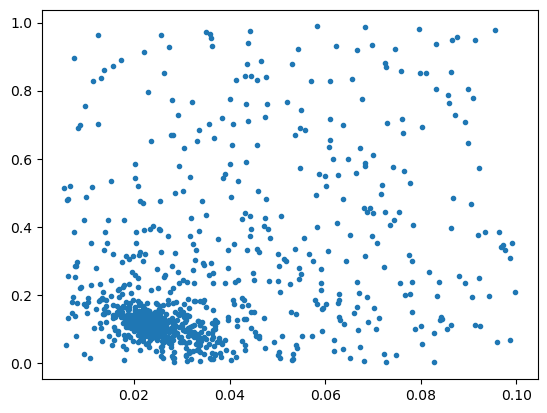

In [39]:
# %load solutions/3.2.4.py
from tqdm import trange

def generate_point(num_repeats=30):

    cov = 0.1*np.cov(live_points.T)
    x0 = np.random.default_rng().choice(live_points)
    logL0 = planck.loglikelihood(x0)
    for _ in range(num_repeats):
        x = scipy.stats.multivariate_normal(x0, cov).rvs()
        logL = planck.loglikelihood(x)
        if logL > live_logLs.min() and planck.prior.pdf(x).prod() > 0:
            x0 = x.copy()
            logL0 = logL

    return x0, logL0

nlive = 50
live_points = planck.prior.rvs((nlive, 6))
live_logLs = planck.loglikelihood(live_points)
live_logL_births = -np.inf * np.ones(nlive)
dead_points = []
dead_logLs = []
dead_logL_births = []

for i in trange(nlive*40):
    x, logL = generate_point()
    dead_points.append(live_points[live_logLs.argmin()].copy())
    dead_logLs.append(live_logLs.min())
    dead_logL_births.append(live_logL_births[live_logLs.argmin()])
    live_points[live_logLs.argmin()] = x
    live_logL_births[live_logLs.argmin()] = live_logLs.min()
    live_logLs[live_logLs.argmin()] = logL

dead_points += live_points.tolist()
dead_logLs += live_logLs.tolist()
dead_logL_births += live_logL_births.tolist()

from anesthetic import NestedSamples
samples = NestedSamples(dead_points, logL=dead_logLs, logL_birth=dead_logL_births)
plt.plot(*samples[[0,1]].to_numpy().T, '.')

## Interlude

 The goal of the above 'my first metropolis algorithm' and 'my first nested sampler' exercises is to give you a feel for how at these algorithms work at the base level, and how they can be implemented, so that you can assess the efficiacy of new ideas. In practice you should use one of the more established libraries for doing this, which have been battle-tested and optimised for speed. In particular, some of the things which cause ~O(10) lines of code to expand to ~O(1000) lines are:
 - robust live point generation
 - parallelisation
 - mode identification & handling

 Most packages focus on the first of these, many (but not all) provide the second, with very few implementing the substantial bookkeeping required for the third.

 As discussed in the talk, samplers 

 #### Rejection samplers (or 'region samplers')
 - [MultiNest](https://github.com/farhanferoz/MultiNest)
   - ellipsoidal decomposition, parallelised, clustered
   - the original nested sampler
   - Incorporated into a wide variety of packages (GAMBIT, CosmoSIS, MontePython, Cobaya, etc)
   - Johannes Buchner implemented a [python wrapper](https://johannesbuchner.github.io/PyMultiNest/)
 - [UltraNest](https://johannesbuchner.github.io/UltraNest/)
   - kernel-based method for generating live points, paralellised
   - Johannes Buchner's new python nested sampler
   - incorporates new advances in nested sampling not in MultiNest
   - python only (so for very fast likelihoods may be worth compiling multinest)
   - also implements many other strategies (including path sampling)
 - [nessai](https://nessai.readthedocs.io/en/latest/)
   - normalising flows to generate live points
   - popular in gravitational waves community

 #### Chain-based samplers (or 'path samplers')
 - [PolyChord](https://github.com/PolyChord/PolyChordLite)
   - slice sampling, parallelised, clustered
   - the original path sampler
 - [pymatnext](https://libatoms.github.io/pymatnest/intro.html)
   - specific for materials science
 
 #### Other samplers
 - [dynesty](https://dynesty.readthedocs.io/en/latest/)
   - python re-implementation of many of the above
   - very popular
   - easy to install
   - defaults not well chosen for path-based samplers
   - although 'dy' is in the name, most nested samplers (polychord, ultranest etc) are now dynamic nested samplers as well

 __Will Handley's recommendations on choosing samplers:__
 - if your problem is low-dimensional ~O(10) parameters, use UltraNest
   - easier for newcomers to install than multinest
   - self-tunes its efficiency parameters, so gives an honest scaling with dimensionality
 - if your problem is high-dimensional, use PolyChord
   - whilst other samplers (dynesty, ultranest) implement slice sampling, neither implement clustering, which is necessary for multi-modal problems
   - in particular dynesty is very poorly parallelised (since it is optimised for notebook rather than HPC work).
   - the dynesty defaults for slice sampling are too generous (and therefore often give wrong, but faster answers)
   - it is slightly harder to install due to the legacy fortran component.

 ### Practical advice for using nested sampling
 Nested sampling run-time scales as:
 $$ T \propto  f_\mathrm{sampler} \times n_\mathrm{live}/n_\mathrm{cores}$$
 providing $n_\mathrm{cores} \le n_\mathrm{live}$.
 - rejection samplers: the $f_\mathrm{sampler} = e^{d/d_0}$ where $d_0$ is problem dependent$.
 - chain-based samplers: the $f_\mathrm{sampler} = \mathcal{O}(3) \times n_\mathrm{repeat}$

 (The proportionality constant is $\mathcal{D}_\mathrm{KL}(\mathcal{P}||\pi) T_\mathrm{like}$)

 This scaling is very useful for planning big runs, all you need to do is determine the proportionality constant, which in practice you get from a preliminary run.

 The strategy is therefore:
 1. run a preliminary run with a small number of live points, debug code, and determine $T_0$.
    - for rejection samplers, you need a minimum number of samples to train the region proxy (ellipsoidal decomposition, normalising flow), usually ~O(500)
    - for path samplers this can be set much lower (as low as 5!)
    - Since nested sampling is parallelised up to the number of cores, setting nlive ~ ncores is a good starting point (e.g. on modern HPC machines ~O(50), on your laptop ~O(10)).
 2. scale up to a production run (nlive ~ 1000)
   - If you had $n_\mathrm{live}^0$ and $n_\mathrm{cores}^0$ giving you $T_0$, the full runtime will be
    $$T = T_0 \times \frac{n_\mathrm{live}}{n_\mathrm{live}^0} \times \frac{n_\mathrm{cores}^0}{n_\mathrm{cores}}$$
   - With arbitrary HPC, you can scale the cores with the live points and retain the same walltime $T_0$.
 3. check that you ran with high enough $f_sampler$ by halving/doubling it and checking the results are consistent.

General advice on usage

## References:
 - [Nature review article](https://arxiv.org/abs/2205.15570): Nested sampling for physical sscientists
   - pedagogical introduction by the community to nested sampling
 - [Technical review article](https://arxiv.org/abs/2101.09675): Nested sampling methods
   - technical review by Johannes Buchner (author of UltraNest)
   - detailed and complete reference list of the entire nested sampling literature up to early 2023.
 - [John Skillings original paper](https://projecteuclid.org/journals/bayesian-analysis/volume-1/issue-4/Nested-sampling-for-general-Bayesian-computation/10.1214/06-BA127.full)
   - original paper on nested sampling
   - a goldmine of insight in John's unique style

## 4. Integration
 
 If your probability distribution is not normalised, the integration constant is of critical importance, either as a cross section (particle physics), a Bayesian evidence (cosmology) or a partition function (statistical mechanics).

 Fundamentally we want to compute:
 $$ Z = \int P^*(x) dx$$
 The traditional discussion begins by pointing out that over the domain of $P^*(x)$, the region where $P^*(x)$ is of non-zero probability is very small, which we don't know a-priori where it is.  On the face of it, this doesn't look like a deal-breaker -- we have been developing ever more sophisticated ways of generating samples $x\sim P$, so we have plenty of points with non-zero $P^*(x)$

 However, there is another portion of the integral, namely $dx$, which posterior samples __do not__ give us. The challenge is therefore not finding the "typical set", or generating points within it, it is measuring its volume.

### 4.1 Importance sampling
 The go-to method in particle physics for doing this is importance sampling.
 The premise here is to find a normalised distribution $Q(x)$ which easy to sample from (for example a scipy distribution), and which is similar to $P^*(x)$ in the region where $P^*(x)$ is non-zero.
 
 One then uses the (almost trivial) result:
 $$ \int P^*(x) dx = \int \frac{P^*(x)}{Q(x)} Q(x) dx = \left\langle \frac{P^*(x)}{Q(x)} \right\rangle_Q$$
 I.e. one generates samples from $x\sim Q(x)$ and computes the average of $P^*(x)/Q(x)$.

 You can think of this intuitively as 'trimming off' the regions where $P^*(x)$ is zero, and then computing the average of the remaining regions -- a more sophisticated way of picking a narrower prior

 If you choose a poor $Q$, then this will be very inefficient, with very few samples contributing to the integral. These weighted samples are in a definite sense exact

__Exercise 4.1.1:__ Take $P^*(x)$ to be the `planck.loglikelihood` added to the `planck.prior.logpdf`, and Q(x) to be a scipy.stats_multivariate_normal with `planck.mean`, `planck.cov`. Compute the integral using importance sampling. You should get `logZ=-1431.403883060199`. You may find it useful to use `scipy.special.logsumexp` to compute the average.

In [40]:
# Answer

In [41]:
# %load solutions/4.1.1.py
Q = scipy.stats.multivariate_normal(planck.mean, planck.cov)
nsamples = 10000
x = Q.rvs(nsamples)
logP = planck.loglikelihood(x)
logpi = planck.prior.logpdf(x).sum(axis=-1)
logQ = Q.logpdf(x)
w = logP + logpi - logQ
print(scipy.special.logsumexp(w) - np.log(nsamples))

-1431.4038830601987


__Exercise 4.1.2:__ Now compute the integral with a slightly misspecified proposal $Q$ by choosing a mean offset by a random amount. Compute the effective number of samples using the formula $$ n = \frac{(\sum_i w_i)^2 }{ \sum_i w_i^2} $$ where $w_i$ are the importance weights we are averaging over

In [42]:
# Answer

In [43]:
# %load solutions/4.1.2.py
mean = scipy.stats.multivariate_normal(planck.mean, planck.cov).rvs()
Q = scipy.stats.multivariate_normal(mean, planck.cov)

nsamples = 10000
x = Q.rvs(nsamples)
logP = planck.loglikelihood(x)
logpi = planck.prior.logpdf(x).sum(axis=-1)
logQ = Q.logpdf(x)
w = logP + logpi - logQ

logZ = scipy.special.logsumexp(w) - np.log(nsamples)
print(f'logZ = {logZ}')

neff = np.exp(2*scipy.special.logsumexp(w) - scipy.special.logsumexp(2*w))
print(f'effective number of samples = {neff}')
print(f'efficiency = {neff/nsamples}')

logZ = -1431.3470215188238
effective number of samples = 445.1489363879362
efficiency = 0.04451489363879362


__Exercise 4.1.2:__ Try other distributions (e.g. multivariate_t, adjusting the covariance matrix using a wishart distribution, etc). How does the efficiency change?

What the above exercise shows is that if you have a good proposal $Q$, then this can be a very efficient way of computing an integral. However, the efficiency drops for even slightly misspecified $Q$, and this problem exponentially worsens in high dimensions

### 4.2 Nested sampling

 Nested sampling provides a more sophisticated way to achieve the above. We begin by making the standard [Lebesgue integral](https://en.wikipedia.org/wiki/Lebesgue_integration) manipulation. First define the volume (/prior volume/measure/CDF) as:
 $$ X(P^*) = \int_{P^*(x)>P^*} dx$$
 this is the volume of the space contained inside each contour of $P^*$.  With this definition, we can say
 $$ Z = \int P^* dx = \int P^* dX \approx \sum_i P^*_i \Delta X_i $$
 which has transformed the multidimensional integral into a one-dimensional one which can be tractably numerically integrated.

The power of nested sampling is that we can estimate $X_i$ from the nested sampling compression procedure:
 $$X_i \approx \frac{n}{n+1} X_{i-1} $$

__Exercise 4.2.1:__ Compute the nested sampling evidence estimate, and compare to the value you found with importance sampling.

In [44]:
# Answer

In [45]:
# %load solutions/4.2.1.py
X0 = np.diff(planck.bounds).prod()
logL_max = max(dead_logLs)
Z = 0
for logL in dead_logLs:
    X1 = X0 * nlive/(nlive+1)
    Z += np.exp(logL-logL_max) * (X0-X1)
    X0 = X1

print(f'logZ = {logL_max+np.log(Z)}')

logZ = -1431.0914776402926


It's a little more involved to quantify the $\approx$ using samples from the distribution of $X_i$, but fortunately anesthetic has implemented all of this for you

<Axes: >

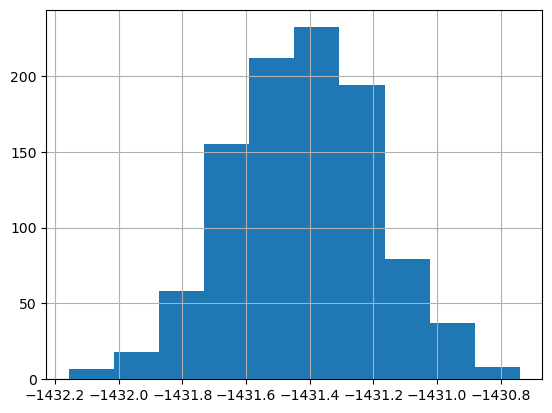

In [46]:
samples = planck_gaussian()
samples.logZ(1000).hist()

and much more besides

<Axes: >

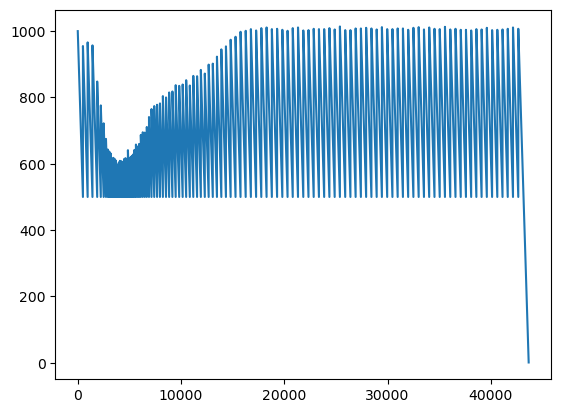

In [47]:
samples.nlive.plot()

and much more besides

In [48]:
samples.stats()

        labels                                    
logZ    $\ln\mathcal{Z}$                             -1431.395998
D_KL    $\mathcal{D}_\mathrm{KL}$                       31.045998
logL_P  $\langle\ln\mathcal{L}\rangle_\mathcal{P}$   -1400.350000
d_G     $d_\mathrm{G}$                                   5.892668
dtype: float64

and much more besides

,logZ,D_KL,logL_P,d_G
logZ,DiagonalAx...,OffDiagona...,OffDiagona...,OffDiagona...
D_KL,OffDiagona...,DiagonalAx...,OffDiagona...,OffDiagona...
logL_P,OffDiagona...,OffDiagona...,DiagonalAx...,OffDiagona...
d_G,OffDiagona...,OffDiagona...,OffDiagona...,DiagonalAx...


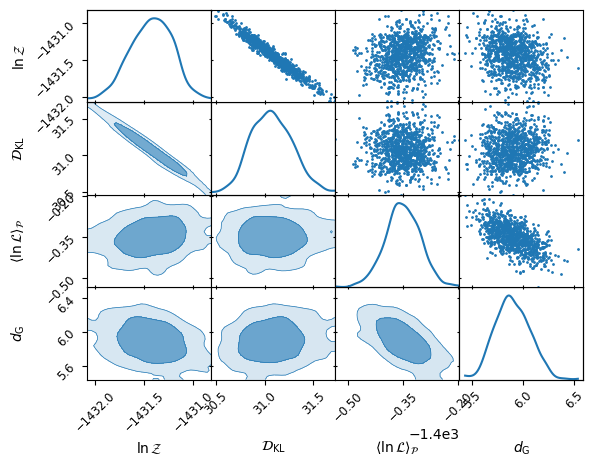

In [49]:
samples.stats(1000).plot_2d()